In [38]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.figsize = (10, 20)

# Helper Function
def display_image(image, title='Press Escape to Quit'):
    cv.imshow(title, image)
    # Press escape to close the image
    if cv.waitKey(0) & 0xff == 27:
        cv.destroyAllWindows()

1. On the following image, apply:
    - Robert
    - Prewitt
    - Sobel
    - Laplacian
    - Laplacian with Gaussian $(5 \times 5)$ with $\sigma = 2$
    - Canny edge detector

    Save the image with edges after each type of detection technique along with the original image (All 7 images on the two page) in a pdf file. Also provide your own
    assessment of each of the filter details that you used in your solution.
    ![](input/input.png)

In [39]:
image = cv.imread("input/input.png", cv.IMREAD_GRAYSCALE)
image = image[:, :800]

In [40]:
def apply_kernel(image, kernel):
  height, width = image.shape
  kernel_height, kernel_width = kernel.shape
  pad_h, pad_w = kernel_height // 2, kernel_width // 2
  
  padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
  modified_image = np.zeros_like(image)
  
  for y in range(height):
    for x in range(width):
      neighborhood = padded_image[y:y+kernel_height, x:x+kernel_width]
      modified_image[y, x] = np.sum(neighborhood * kernel)
      
  return modified_image

def create_gaussian_blur_kernel(size, sigma):
    half_block = size // 2
    one_d_kernel = np.exp(-np.arange(-half_block, half_block+1)**2 / (2 * sigma**2))
    two_d_kernel = np.outer(one_d_kernel, one_d_kernel)
    normalized_gaussian_kernel = two_d_kernel / np.sum(two_d_kernel)
    return normalized_gaussian_kernel
gaussian_kernel = create_gaussian_blur_kernel(5, 2)

In [41]:
roberts_x = np.matrix([[1, 0],
                       [0, -1]])
roberts_y = np.matrix([[0, 1],
                       [-1, 0]])

prewitt_x = np.matrix([[-1, 0, 1],
                       [-1, 0, 1],
                       [-1, 0, 1]])
prewitt_y = np.matrix([[ 1,  1,  1],
                       [ 0,  0,  0],
                       [-1, -1, -1]])

sobel_x = np.matrix([[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])
sobel_y = np.matrix([[ 1,  2,  1],
                     [ 0,  0,  0],
                     [-1, -2, -1]])

laplacian = np.matrix([[1,  4 , 1],
                       [4, -20, 4],
                       [1,  4 , 1]])

LoG = np.matrix([[ 0,  0, -1,  0,  0],
                 [ 0, -1, -2, -1,  0],
                 [-1, -2, 16, -2, -1],
                 [ 0, -1, -2, -1,  0],
                 [ 0,  0, -1,  0,  0]])


In [42]:
def apply_vector_edge_detection(image, kernel_x, kernel_y, name):
    gradient_x = apply_kernel(image, kernel_x)
    gradient_y = apply_kernel(image, kernel_y)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x)
    
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    fig.delaxes(ax[1, 2])
    
    ax[0, 0].imshow(image, cmap='gray')
    ax[0, 0].set_title('Original Image')
    
    ax[0, 1].imshow(gradient_x, cmap='gray')
    ax[0, 1].set_title(f'{name} X')
    
    ax[0, 2].imshow(gradient_y, cmap='gray')
    ax[0, 2].set_title(f'{name} Y')
    
    ax[1, 0].imshow(gradient_magnitude, cmap='gray')
    ax[1, 0].set_title(f'{name} Magnitude')
    
    interval = 30
    y, x = np.mgrid[interval//2:image.shape[0]:interval, interval//2:image.shape[1]:interval]
    u = np.cos(gradient_direction[y, x])
    v = np.sin(gradient_direction[y, x])
    ax[1, 1].quiver(x, y, u, v, scale=40)
    ax[1, 1].set_title(f'{name} Direction')
    ax[1, 1].invert_yaxis()

    fig.suptitle(f'{name} Edge Detection')
    plt.tight_layout()
    plt.savefig(f'output/basic/{name}.png')
    plt.show()
    

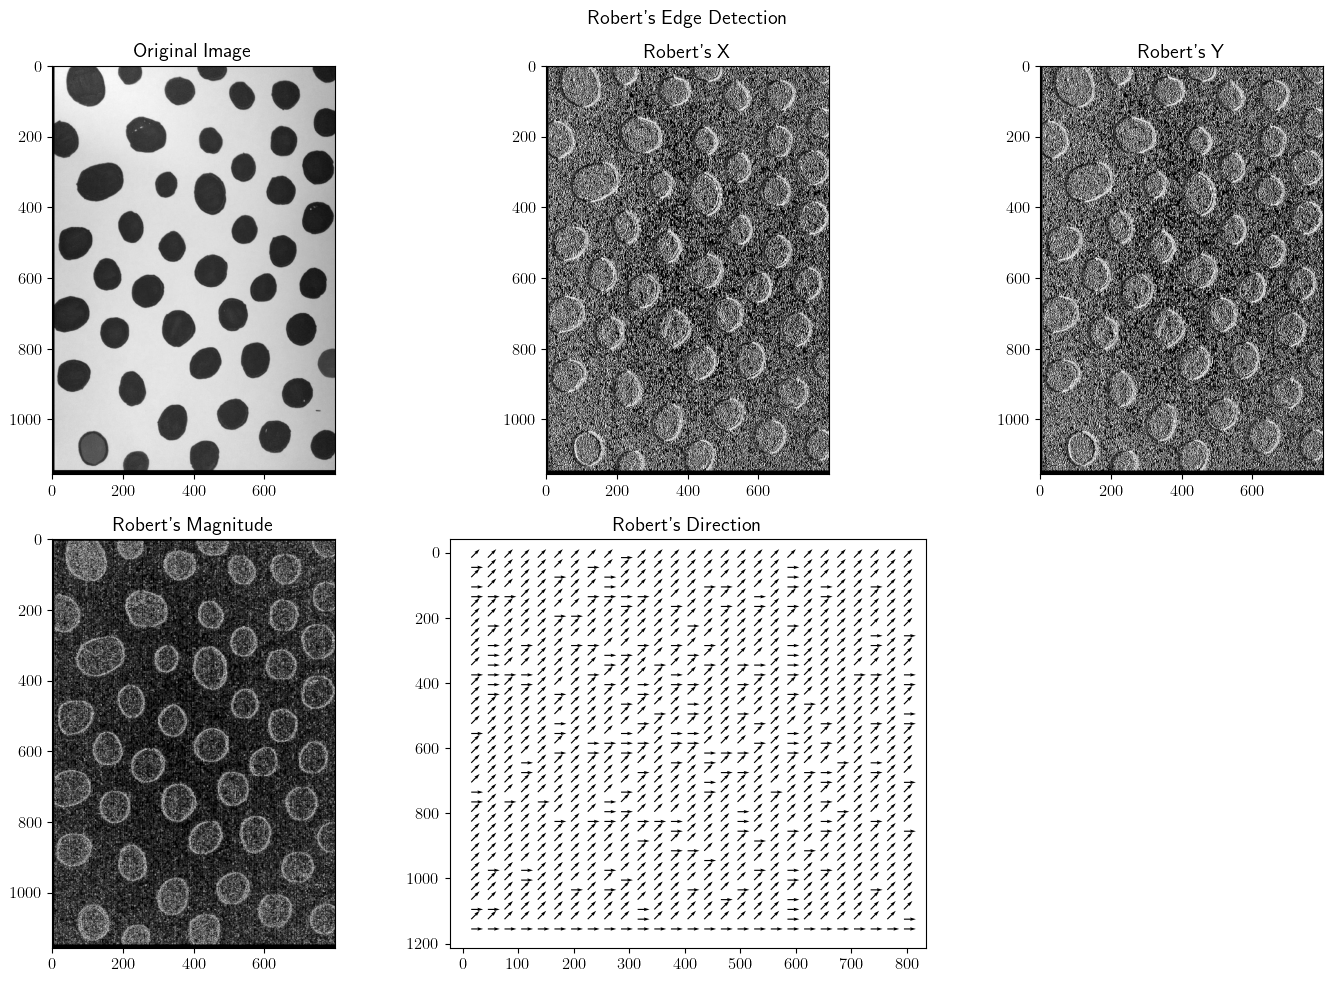

In [43]:
apply_vector_edge_detection(image, roberts_x, roberts_y, 'Robert\'s')

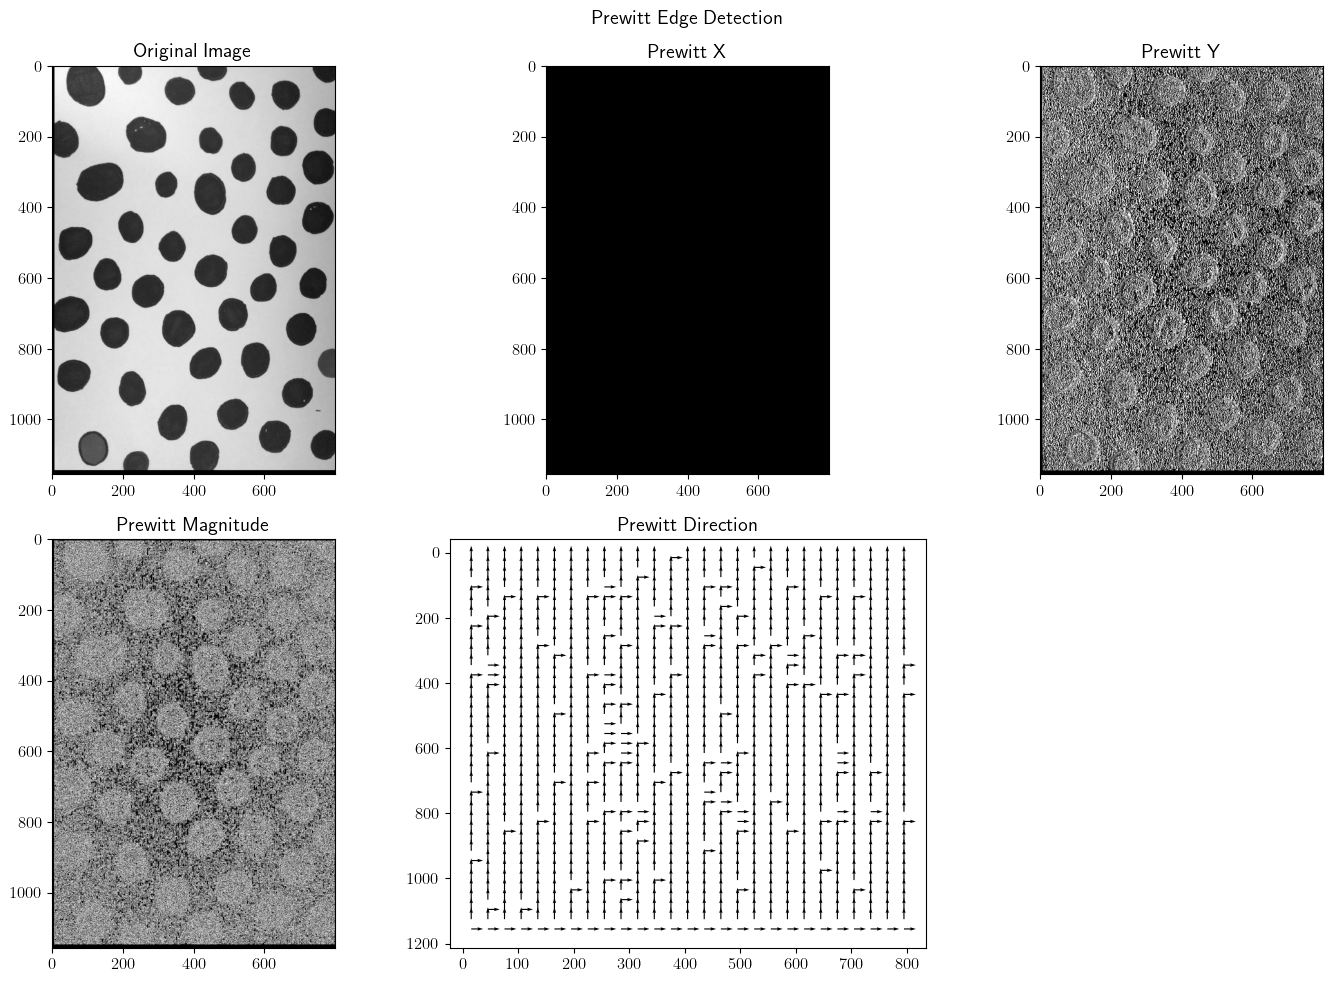

In [44]:
apply_vector_edge_detection(image, prewitt_x, prewitt_y, 'Prewitt')

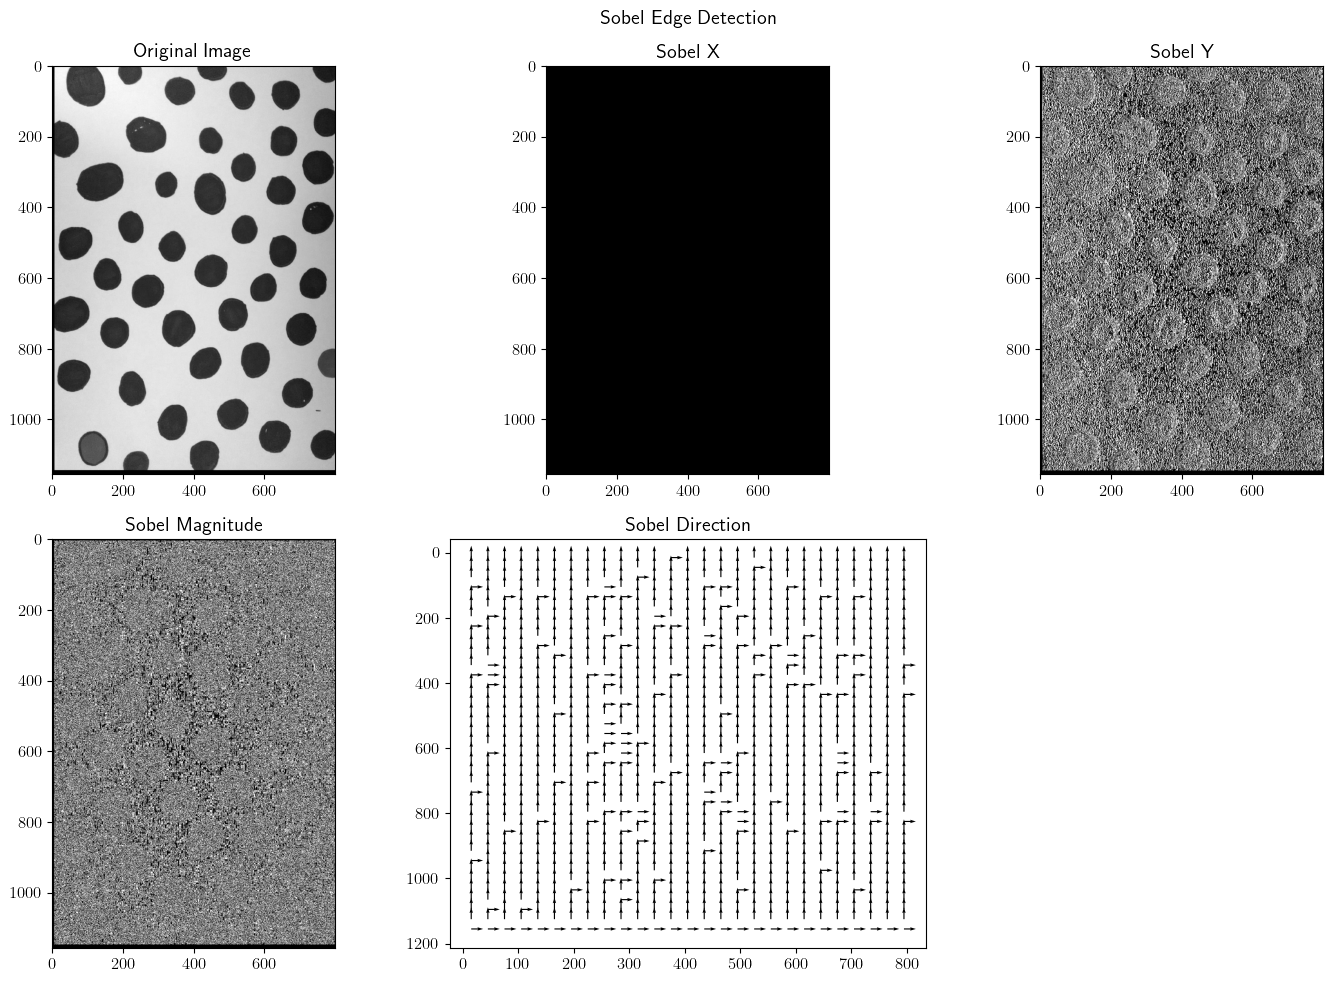

In [45]:
apply_vector_edge_detection(image, sobel_x, sobel_y, 'Sobel')

In [46]:
def apply_scalar_edge_detection(image, kernel, name):
    filtered_image = apply_kernel(image, kernel)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    
    ax[1].imshow(filtered_image, cmap='gray')
    ax[1].set_title(f'{name}')
    
    fig.suptitle(f'{name} Edge Detection')
    plt.tight_layout()
    plt.savefig(f'output/basic/{name}.png')
    plt.show()

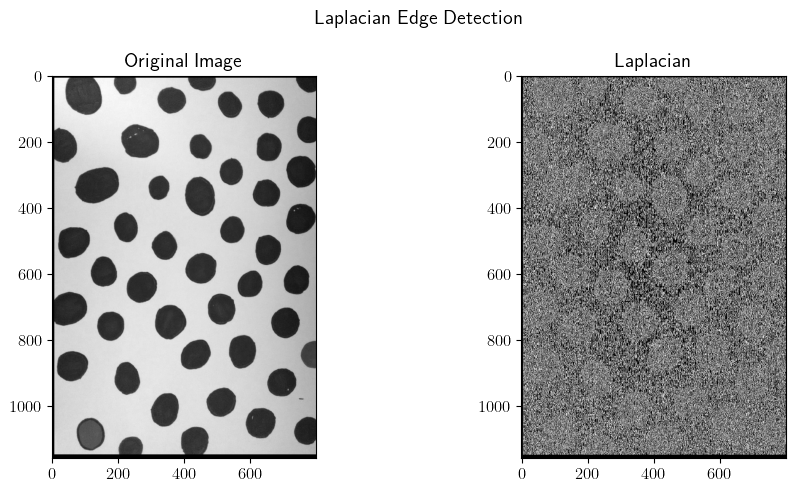

In [47]:
apply_scalar_edge_detection(image, laplacian, "Laplacian")

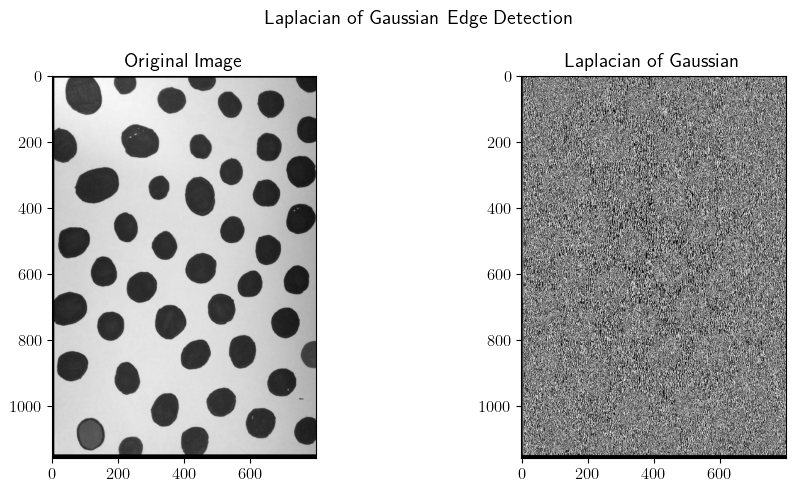

In [48]:
apply_scalar_edge_detection(image, LoG, "Laplacian of Gaussian")

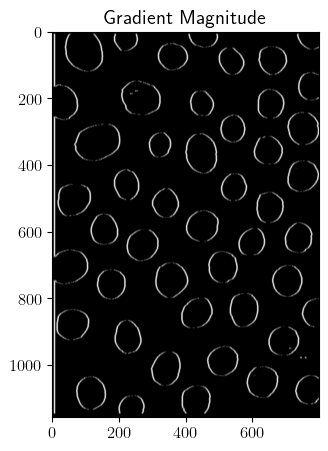

In [49]:
thresholded_image = (image > np.mean(image)) * 255
# Canny edge detection algorithm
smoothened_image = apply_kernel(thresholded_image, gaussian_kernel)

gradient_x = apply_kernel(smoothened_image, roberts_x)
gradient_y = apply_kernel(smoothened_image, roberts_y)
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_direction = np.arctan2(gradient_y, gradient_x)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(gradient_magnitude, cmap='gray')
ax.set_title('Gradient Magnitude')
plt.savefig('output/canny/1_gradient.png')
plt.show()

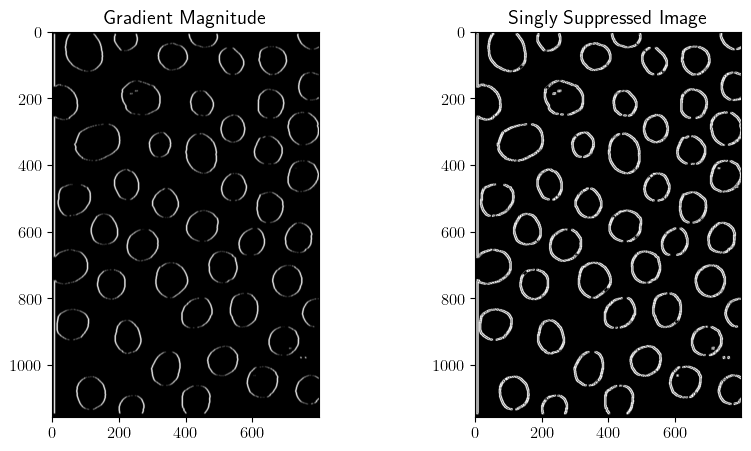

In [53]:
def non_maximum_suppression(gradient_magnitude, gradient_direction):
    height, width = gradient_magnitude.shape
    suppressed_image = np.zeros_like(gradient_magnitude, dtype=np.float32)
    angle = gradient_direction * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            q = 255
            r = 255

            # 0° sector
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = gradient_magnitude[i, j+1]
                r = gradient_magnitude[i, j-1]
            # 45° sector
            elif (22.5 <= angle[i,j] < 67.5):
                q = gradient_magnitude[i+1, j-1]
                r = gradient_magnitude[i-1, j+1]
            # 90° sector
            elif (67.5 <= angle[i,j] < 112.5):
                q = gradient_magnitude[i+1, j]
                r = gradient_magnitude[i-1, j]
            # 135° sector
            elif (112.5 <= angle[i,j] < 157.5):
                q = gradient_magnitude[i-1, j-1]
                r = gradient_magnitude[i+1, j+1]

            if (gradient_magnitude[i,j] >= q) and (gradient_magnitude[i,j] >= r):
                suppressed_image[i,j] = 0
            else:
                suppressed_image[i,j] = 255

    return suppressed_image
  
suppressed_image = non_maximum_suppression(gradient_magnitude, gradient_direction)
suppressed_image = (suppressed_image > np.mean(suppressed_image)) * 255

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(gradient_magnitude, cmap='gray')
ax[0].set_title('Gradient Magnitude')
ax[1].imshow(suppressed_image, cmap='gray')
ax[1].set_title('Singly Suppressed Image')
plt.savefig('output/canny/2_non_max_suppression.png')
plt.show()

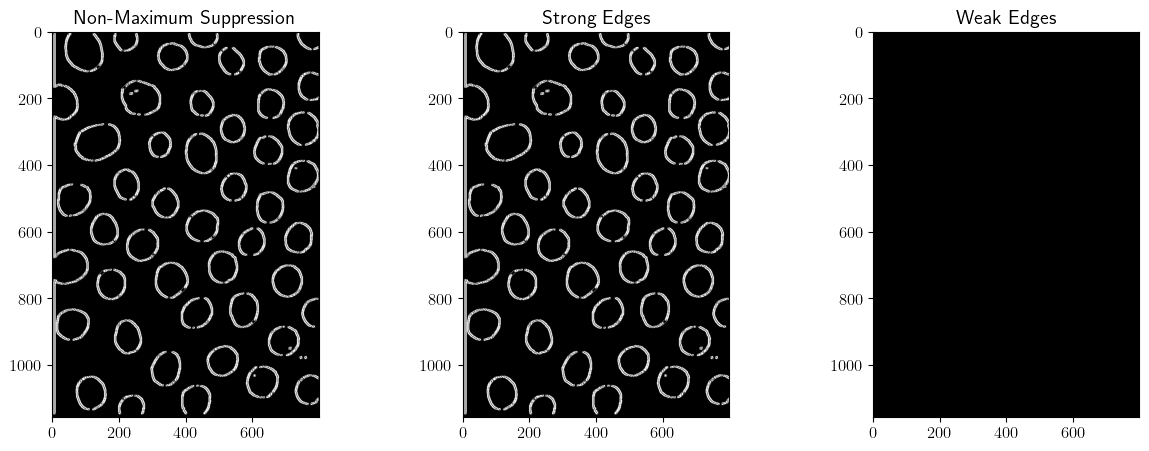

In [54]:
def double_thresholding(image, low_threshold, high_threshold):
    strong_edges = (image >= high_threshold).astype(np.uint8)
    weak_edges = ((image >= low_threshold) & (image < high_threshold)).astype(np.uint8)
    return strong_edges, weak_edges

high_threshold = 0.20 * np.max(suppressed_image)
low_threshold = 0.05 * np.max(suppressed_image)
strong_edges, weak_edges = double_thresholding(suppressed_image, low_threshold, high_threshold)

strong_edges_normalized = strong_edges * 255
weak_edges_normalized = weak_edges * 128

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(suppressed_image, cmap='gray')
ax[0].set_title('Non-Maximum Suppression')
ax[1].imshow(strong_edges_normalized, cmap='gray')
ax[1].set_title('Strong Edges')
ax[2].imshow(weak_edges_normalized, cmap='gray')
ax[2].set_title('Weak Edges')
plt.savefig('output/canny/3_double_threshold.png')
plt.show()